In [28]:
import os
from glob import glob
import shutil
from pathlib import Path, PurePath
import json
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from PIL import Image
import cv2

import segmentation_models_pytorch as smp

from torchvision import transforms as T
from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split

In [29]:
%matplotlib inline
torch.manual_seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [30]:
IMAGES = './train/images'
MASKS = './train/masks'
classes_csv = './train/classes.csv'

PATCH_IMAGES_DIR = './train_patched/images'
PATCH_MASKS_DIR = './train_patched/masks'

In [31]:
def create_tiles(img, mask, size=256, threshold=0.01, min_classes=2):
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)
    mask_tensor = torch.from_numpy(mask)

    img_patches = img_tensor.unfold(1, size, size).unfold(2, size, size)
    img_patches = img_patches.contiguous().view(3, -1, size, size).permute(1, 0, 2, 3)

    mask_patches = mask_tensor.unfold(0, size, size).unfold(1, size, size)
    mask_patches = mask_patches.contiguous().view(-1, size, size)

    keep_indices = []
    for i, patch in enumerate(mask_patches):
        unique_classes = torch.unique(patch)
        foreground_pixels = (patch != 0).sum().item()
        foreground_ratio = foreground_pixels / (size * size)
        
        if len(unique_classes) >= min_classes or foreground_ratio > threshold or np.random.rand() < 0.1:
            keep_indices.append(i)

    if not keep_indices:
        keep_indices.append(np.random.randint(0, len(img_patches)))

    return img_patches[keep_indices], mask_patches[keep_indices]

In [32]:
os.makedirs(PATCH_IMAGES_DIR, exist_ok=True)
os.makedirs(PATCH_MASKS_DIR, exist_ok=True)

if not os.listdir(PATCH_IMAGES_DIR):
    print("Preprocessing patches... This will only run once.")
    original_filenames = sorted([os.path.splitext(f)[0] for f in os.listdir(IMAGES)])
    
    for filename in tqdm(original_filenames, desc="Generating and Saving Patches"):
        img_path = os.path.join(IMAGES, filename + ".jpg")
        mask_path = os.path.join(MASKS, filename + "_mask.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is not None:
            mask[mask == 3] = 255

        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        img_patches, mask_patches = create_tiles(img, mask)

        for i in range(len(img_patches)):
            patch_img_np = img_patches[i].permute(1, 2, 0).numpy()
            patch_mask_np = mask_patches[i].numpy()

            save_img_path = os.path.join(PATCH_IMAGES_DIR, f"{filename}_{i}.png")
            cv2.imwrite(save_img_path, cv2.cvtColor(patch_img_np, cv2.COLOR_RGB2BGR))

            save_mask_path = os.path.join(PATCH_MASKS_DIR, f"{filename}_{i}_mask.png")
            cv2.imwrite(save_mask_path, patch_mask_np)
    print("Patch preprocessing complete.")
else:
    print("Patched data already exists. Skipping preprocessing.")

Patched data already exists. Skipping preprocessing.


In [33]:
class PorosityPatchedDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, mean, std, transform=None):
        self.img_dir = image_dir
        self.mask_dir = mask_dir
        self.x = filenames
        self.mean = mean
        self.std = std
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image_filename = self.x[idx]
        mask_filename = os.path.splitext(image_filename)[0] + "_mask.png"
        
        img_path = os.path.join(self.img_dir, image_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [34]:
def custom_collate(batch):
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    return images, masks

In [35]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, ignore_index=255): # Updated ignore_index
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        loss = ((1 - pt) ** self.gamma) * -logpt
        return loss.mean()

class DiceLoss(nn.Module):
    def __init__(self, n_classes, ignore_index=255):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.ignore_index = ignore_index

    def forward(self, input, target, smooth=1e-6):
        input_soft = F.softmax(input, dim=1)
        
        if self.ignore_index is not None:
            mask = target != self.ignore_index
            target = target[mask]
            input_soft = input_soft.permute(0, 2, 3, 1)[mask.unsqueeze(-1).expand_as(input_soft.permute(0, 2, 3, 1))]
            input_soft = input_soft.reshape(-1, self.n_classes)


        target_one_hot = F.one_hot(target, num_classes=self.n_classes).float()
        
        input_flat = input_soft.contiguous().view(-1)
        target_flat = target_one_hot.contiguous().view(-1)
        
        intersection = (input_flat * target_flat).sum()
        dice_score = (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        return 1 - dice_score

class DiceFocalLoss(nn.Module):
    def __init__(self, n_classes, weight=None, gamma=2, alpha=0.5, ignore_index=-100):
        super(DiceFocalLoss, self).__init__()
        self.alpha = alpha
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma, ignore_index=ignore_index)
        self.dice_loss = DiceLoss(n_classes=n_classes, ignore_index=ignore_index)

    def forward(self, input, target):
        focal = self.focal_loss(input, target)
        dice = self.dice_loss(input, target)
        return self.alpha * focal + (1 - self.alpha) * dice


In [36]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [37]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6, ignore_index=0):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for c in range(n_classes):
            true_class = pred_mask == c
            true_label = mask == c

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [38]:
def compute_per_class_iou(preds, labels, num_classes=6):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [40]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, num_classes=6):
    train_losses, val_losses = [], []
    train_iou, val_iou = [], []
    train_acc, val_acc = [], []
    lrs = []
    min_loss = np.inf
    no_improve = 0

    model.to(device)
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        running_loss, running_iou, running_acc, total_batches = 0, 0, 0, 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            running_iou += mIoU(outputs, masks)
            running_acc += pixel_accuracy(outputs, masks)
            total_batches += 1
            lrs.append(get_lr(optimizer))

        model.eval()
        val_loss, val_iou_score, val_accuracy, val_batches = 0, 0, 0, 0
        all_class_ious = []
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                val_iou_score += mIoU(outputs, masks)
                val_accuracy += pixel_accuracy(outputs, masks)

                preds = torch.argmax(outputs, dim=1)
                for pred, true_mask in zip(preds, masks):
                    all_class_ious.append(compute_per_class_iou(pred, true_mask, num_classes))
                val_batches += 1
        
        avg_train_loss = running_loss / total_batches
        avg_val_loss = val_loss / val_batches
        avg_train_iou = running_iou / total_batches
        avg_val_iou = val_iou_score / val_batches
        avg_train_acc = running_acc / total_batches
        avg_val_acc = val_accuracy / val_batches

        train_losses.append(avg_train_loss); val_losses.append(avg_val_loss)
        train_iou.append(avg_train_iou); val_iou.append(avg_val_iou)
        train_acc.append(avg_train_acc); val_acc.append(avg_val_acc)
        
        mean_class_ious = np.nanmean(np.array(all_class_ious), axis=0)

        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train mIoU: {avg_train_iou:.4f}, Val mIoU: {avg_val_iou:.4f}, "
              f"Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}, "
              f"LR: {lrs[-1]:.6f}, "
              f"Time: {(time.time() - epoch_start)/60:.2f} mins")

        print("\nðŸ“Š Per-class IoU (Validation):")
        for i, iou in enumerate(mean_class_ious):
            print(f"  Class {i}: IoU = {iou:.4f}")

        if avg_val_loss < min_loss:
            print(f"Validation loss decreased ({min_loss:.4f} -> {avg_val_loss:.4f}). Saving model.")
            min_loss = avg_val_loss
            no_improve = 0
            torch.save(model.state_dict(), 'model_transfer_learning.pt')
        else:
            no_improve += 1
            print(f"No improvement in validation loss for {no_improve} epochs.")
            if no_improve >= 10:
                print("Early stopping triggered.")
                break

    total_time = (time.time() - start_time) / 60
    print(f"\nTraining completed in {total_time:.2f} minutes.")
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_miou': train_iou, 'val_miou': val_iou, 'train_acc': train_acc, 'val_acc': val_acc, 'lrs': lrs}
    return history

In [41]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [42]:
t_train = A.Compose([A.VerticalFlip(), A.HorizontalFlip(), A.GridDistortion(p=0.2),
                     A.GaussNoise(), A.RandomBrightnessContrast((0, 0.5), (0, 0.5))])
t_val = A.Compose([A.HorizontalFlip(), A.GridDistortion(p=0.2)])

In [43]:
x_all_patches = sorted(os.listdir(PATCH_IMAGES_DIR))
x_temp, x_test = train_test_split(x_all_patches, test_size=0.10, random_state=42)
x_train, x_val = train_test_split(x_temp, test_size=0.10, random_state=42)

In [44]:
train_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_train, mean, std, t_train)
val_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_val, mean, std, t_val)
test_dataset = PorosityPatchedDataset(PATCH_IMAGES_DIR, PATCH_MASKS_DIR, x_test, mean, std, t_val)

In [45]:
batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [46]:
def get_class_distribution(dataset, num_classes=6):
    class_counts = np.zeros(num_classes, dtype=int)
    for _, mask in DataLoader(dataset, batch_size=1):
        for m in mask:
            for cls in range(num_classes):
                class_counts[cls] += torch.sum(m == cls).item()
    return class_counts

train_class_counts = get_class_distribution(train_dataset)
val_class_counts = get_class_distribution(val_dataset)

print("Train class distribution:", train_class_counts)
print("Val class distribution:", val_class_counts)

Train class distribution: [148923074    327874    477657         0     82728    163245]
Val class distribution: [16662064    86990     3901        0     9404    17008]


In [47]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)

In [48]:
def get_class_weights_from_masks(
    masks_dir, 
    num_classes=6, 
    background_class_id=0, 
    background_weight_multiplier=0.01,
):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total_pixels = 0

    for mask_name in os.listdir(masks_dir):
        if mask_name.endswith(".png"):
            mask_path = os.path.join(masks_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask is not None:
                total_pixels += mask.size
                for cls in range(num_classes):
                    class_counts[cls] += np.sum(mask == cls)
    
    class_frequencies = class_counts / total_pixels
    class_frequencies[class_frequencies == 0] = 1e-6
    
    class_weights = 5.0 / class_frequencies
    
    class_weights[background_class_id] *= background_weight_multiplier
    
    class_weights = class_weights * (num_classes / np.sum(class_weights))
    
    return torch.tensor(class_weights, dtype=torch.float32)

In [49]:
class_weights = get_class_weights_from_masks(PATCH_MASKS_DIR, num_classes=6)
class_weights = class_weights.to(device)
print(f"Using class weights: {class_weights}")

Using class weights: tensor([7.1877e-08, 2.7203e-03, 2.7118e-03, 5.9746e+00, 1.3338e-02, 6.6449e-03],
       device='mps:0')


In [50]:
max_lr = 1e-3
epoch = 100
weight_decay = 1e-4

In [51]:
boost_factor = 10.0
class_weights[1] *= boost_factor
class_weights[2] *= boost_factor
class_weights[4] *= boost_factor
class_weights[5] *= boost_factor

In [52]:
class_weights = class_weights.to(device)

In [53]:
criterion = DiceFocalLoss(
    n_classes=6,
    weight=class_weights,
    gamma=2,
    alpha=0.75,
    ignore_index=255
)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

In [54]:
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch 1 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:43<00:00,  2.19s/it]


Epoch [1/100] - Train Loss: 1.0698, Val Loss: 0.7141, Train mIoU: 0.0240, Val mIoU: 0.0306, Train Acc: 0.0888, Val Acc: 0.1078, LR: 0.000043, Time: 9.15 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.1075
  Class 1: IoU = 0.0014
  Class 2: IoU = 0.0000
  Class 3: IoU = 0.0000
  Class 4: IoU = 0.0003
  Class 5: IoU = 0.0100
Validation loss decreased (inf -> 0.7141). Saving model.


Epoch 2 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:43<00:00,  2.18s/it]


Epoch [2/100] - Train Loss: 0.7916, Val Loss: 0.5969, Train mIoU: 0.0153, Val mIoU: 0.0307, Train Acc: 0.0533, Val Acc: 0.1062, LR: 0.000050, Time: 12.43 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.1050
  Class 1: IoU = 0.0004
  Class 2: IoU = 0.0000
  Class 3: IoU = 0.0000
  Class 4: IoU = 0.0007
  Class 5: IoU = 0.0122
Validation loss decreased (0.7141 -> 0.5969). Saving model.


Epoch 3 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:46<00:00,  2.34s/it]


Epoch [3/100] - Train Loss: 0.6811, Val Loss: 0.5214, Train mIoU: 0.0249, Val mIoU: 0.1224, Train Acc: 0.0921, Val Acc: 0.4485, LR: 0.000064, Time: 16.13 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.4419
  Class 1: IoU = 0.0002
  Class 2: IoU = 0.0000
  Class 3: IoU = 0.0000
  Class 4: IoU = 0.0014
  Class 5: IoU = 0.0266
Validation loss decreased (0.5969 -> 0.5214). Saving model.


Epoch 4 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:47<00:00,  2.37s/it]


Epoch [4/100] - Train Loss: 0.6116, Val Loss: 0.5474, Train mIoU: 0.0665, Val mIoU: 0.1217, Train Acc: 0.2584, Val Acc: 0.4781, LR: 0.000082, Time: 14.02 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.4769
  Class 1: IoU = 0.0001
  Class 2: IoU = 0.0000
  Class 3: IoU = 0.0000
  Class 4: IoU = 0.0020
  Class 5: IoU = 0.0084
No improvement in validation loss for 1 epochs.


Epoch 5 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:38<00:00,  1.92s/it]


Epoch [5/100] - Train Loss: 0.5573, Val Loss: 0.4070, Train mIoU: 0.0900, Val mIoU: 0.1217, Train Acc: 0.3567, Val Acc: 0.4522, LR: 0.000104, Time: 29.07 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.4383
  Class 1: IoU = 0.0002
  Class 2: IoU = 0.0000
  Class 3: IoU = 0.0000
  Class 4: IoU = 0.0014
  Class 5: IoU = 0.0135
Validation loss decreased (0.5214 -> 0.4070). Saving model.


Epoch 6 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:28<00:00,  1.41s/it]
/var/folders/bb/qsf9jl617j9cqyd0mvk3wzfh0000gn/T/ipykernel_10086/1951146847.py:64: RuntimeWarning: Mean of empty slice
  mean_class_ious = np.nanmean(np.array(all_class_ious), axis=0)


Epoch [6/100] - Train Loss: 0.5573, Val Loss: 0.4356, Train mIoU: 0.1015, Val mIoU: 0.1386, Train Acc: 0.4044, Val Acc: 0.5441, LR: 0.000132, Time: 9.98 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.5361
  Class 1: IoU = 0.0001
  Class 2: IoU = 0.0002
  Class 3: IoU = nan
  Class 4: IoU = 0.0018
  Class 5: IoU = 0.0128
No improvement in validation loss for 1 epochs.


Epoch 7 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:39<00:00,  1.97s/it]


Epoch [7/100] - Train Loss: 0.5206, Val Loss: 0.4450, Train mIoU: 0.1208, Val mIoU: 0.1457, Train Acc: 0.5070, Val Acc: 0.5835, LR: 0.000163, Time: 10.64 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.5799
  Class 1: IoU = 0.0005
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0035
  Class 5: IoU = 0.0154
No improvement in validation loss for 2 epochs.


Epoch 8 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:40<00:00,  2.02s/it]


Epoch [8/100] - Train Loss: 0.5338, Val Loss: 0.4298, Train mIoU: 0.1288, Val mIoU: 0.1685, Train Acc: 0.5452, Val Acc: 0.7194, LR: 0.000199, Time: 13.23 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7132
  Class 1: IoU = 0.0005
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0045
  Class 5: IoU = 0.0164
No improvement in validation loss for 3 epochs.


Epoch 9 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:49<00:00,  2.48s/it]


Epoch [9/100] - Train Loss: 0.5041, Val Loss: 0.4707, Train mIoU: 0.1344, Val mIoU: 0.1673, Train Acc: 0.5707, Val Acc: 0.6958, LR: 0.000238, Time: 14.26 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.6892
  Class 1: IoU = 0.0002
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0032
  Class 5: IoU = 0.0193
No improvement in validation loss for 4 epochs.


Epoch 10 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:53<00:00,  2.67s/it]


Epoch [10/100] - Train Loss: 0.5206, Val Loss: 0.5888, Train mIoU: 0.1445, Val mIoU: 0.1365, Train Acc: 0.6259, Val Acc: 0.5993, LR: 0.000280, Time: 15.70 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.6188
  Class 1: IoU = 0.0004
  Class 2: IoU = 0.0005
  Class 3: IoU = nan
  Class 4: IoU = 0.0026
  Class 5: IoU = 0.0259
No improvement in validation loss for 5 epochs.


Epoch 11 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:06<00:00,  3.34s/it]


Epoch [11/100] - Train Loss: 0.5294, Val Loss: 0.6191, Train mIoU: 0.1518, Val mIoU: 0.1663, Train Acc: 0.6560, Val Acc: 0.7090, LR: 0.000325, Time: 17.69 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7002
  Class 1: IoU = 0.0048
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0045
  Class 5: IoU = 0.0146
No improvement in validation loss for 6 epochs.


Epoch 12 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:34<00:00,  1.74s/it]


Epoch [12/100] - Train Loss: 0.5037, Val Loss: 0.6557, Train mIoU: 0.1482, Val mIoU: 0.1765, Train Acc: 0.6418, Val Acc: 0.7481, LR: 0.000372, Time: 12.42 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7402
  Class 1: IoU = 0.0017
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0054
  Class 5: IoU = 0.0241
No improvement in validation loss for 7 epochs.


Epoch 13 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:34<00:00,  1.74s/it]


Epoch [13/100] - Train Loss: 0.5211, Val Loss: 0.4018, Train mIoU: 0.1564, Val mIoU: 0.1849, Train Acc: 0.6748, Val Acc: 0.7473, LR: 0.000420, Time: 12.39 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7440
  Class 1: IoU = 0.0034
  Class 2: IoU = 0.0020
  Class 3: IoU = nan
  Class 4: IoU = 0.0094
  Class 5: IoU = 0.0366
Validation loss decreased (0.4070 -> 0.4018). Saving model.


Epoch 14 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:33<00:00,  1.70s/it]


Epoch [14/100] - Train Loss: 0.5043, Val Loss: 0.4810, Train mIoU: 0.1534, Val mIoU: 0.1815, Train Acc: 0.6632, Val Acc: 0.7633, LR: 0.000470, Time: 12.85 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7571
  Class 1: IoU = 0.0057
  Class 2: IoU = 0.0020
  Class 3: IoU = nan
  Class 4: IoU = 0.0044
  Class 5: IoU = 0.0294
No improvement in validation loss for 1 epochs.


Epoch 15 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:40<00:00,  2.00s/it]


Epoch [15/100] - Train Loss: 0.5137, Val Loss: 0.6847, Train mIoU: 0.1532, Val mIoU: 0.1853, Train Acc: 0.6610, Val Acc: 0.7673, LR: 0.000520, Time: 12.97 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7577
  Class 1: IoU = 0.0094
  Class 2: IoU = 0.0027
  Class 3: IoU = nan
  Class 4: IoU = 0.0061
  Class 5: IoU = 0.0365
No improvement in validation loss for 2 epochs.


Epoch 16 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:36<00:00,  1.84s/it]


Epoch [16/100] - Train Loss: 0.5265, Val Loss: 0.3577, Train mIoU: 0.1583, Val mIoU: 0.1751, Train Acc: 0.6620, Val Acc: 0.7284, LR: 0.000570, Time: 13.34 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7214
  Class 1: IoU = 0.0026
  Class 2: IoU = 0.0010
  Class 3: IoU = nan
  Class 4: IoU = 0.0100
  Class 5: IoU = 0.0282
Validation loss decreased (0.4018 -> 0.3577). Saving model.


Epoch 17 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:43<00:00,  2.19s/it]


Epoch [17/100] - Train Loss: 0.5238, Val Loss: 0.5106, Train mIoU: 0.1538, Val mIoU: 0.1766, Train Acc: 0.6643, Val Acc: 0.7385, LR: 0.000620, Time: 15.23 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7334
  Class 1: IoU = 0.0041
  Class 2: IoU = 0.0002
  Class 3: IoU = nan
  Class 4: IoU = 0.0047
  Class 5: IoU = 0.0270
No improvement in validation loss for 1 epochs.


Epoch 18 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:39<00:00,  1.97s/it]


Epoch [18/100] - Train Loss: 0.5132, Val Loss: 0.4346, Train mIoU: 0.1507, Val mIoU: 0.1620, Train Acc: 0.6482, Val Acc: 0.6944, LR: 0.000668, Time: 14.68 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.6856
  Class 1: IoU = 0.0053
  Class 2: IoU = 0.0003
  Class 3: IoU = nan
  Class 4: IoU = 0.0041
  Class 5: IoU = 0.0151
No improvement in validation loss for 2 epochs.


Epoch 19 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:52<00:00,  2.63s/it]


Epoch [19/100] - Train Loss: 0.5149, Val Loss: 0.4440, Train mIoU: 0.1531, Val mIoU: 0.1653, Train Acc: 0.6530, Val Acc: 0.6957, LR: 0.000715, Time: 16.35 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.6920
  Class 1: IoU = 0.0014
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0029
  Class 5: IoU = 0.0253
No improvement in validation loss for 3 epochs.


Epoch 20 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:50<00:00,  2.51s/it]


Epoch [20/100] - Train Loss: 0.5151, Val Loss: 0.3865, Train mIoU: 0.1554, Val mIoU: 0.1812, Train Acc: 0.6512, Val Acc: 0.7602, LR: 0.000760, Time: 14.67 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7542
  Class 1: IoU = 0.0053
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0096
  Class 5: IoU = 0.0222
No improvement in validation loss for 4 epochs.


Epoch 21 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:44<00:00,  2.21s/it]


Epoch [21/100] - Train Loss: 0.5359, Val Loss: 0.3857, Train mIoU: 0.1521, Val mIoU: 0.1798, Train Acc: 0.6634, Val Acc: 0.7519, LR: 0.000802, Time: 14.81 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7448
  Class 1: IoU = 0.0037
  Class 2: IoU = 0.0001
  Class 3: IoU = nan
  Class 4: IoU = 0.0079
  Class 5: IoU = 0.0254
No improvement in validation loss for 5 epochs.


Epoch 22 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:42<00:00,  2.15s/it]


Epoch [22/100] - Train Loss: 0.4864, Val Loss: 0.4308, Train mIoU: 0.1546, Val mIoU: 0.1731, Train Acc: 0.6722, Val Acc: 0.7272, LR: 0.000841, Time: 15.09 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7191
  Class 1: IoU = 0.0055
  Class 2: IoU = 0.0001
  Class 3: IoU = nan
  Class 4: IoU = 0.0047
  Class 5: IoU = 0.0270
No improvement in validation loss for 6 epochs.


Epoch 23 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:13<00:00,  3.67s/it]


Epoch [23/100] - Train Loss: 0.5158, Val Loss: 0.5252, Train mIoU: 0.1611, Val mIoU: 0.1707, Train Acc: 0.6978, Val Acc: 0.7192, LR: 0.000877, Time: 19.89 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7124
  Class 1: IoU = 0.0043
  Class 2: IoU = 0.0010
  Class 3: IoU = nan
  Class 4: IoU = 0.0037
  Class 5: IoU = 0.0215
No improvement in validation loss for 7 epochs.


Epoch 24 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:26<00:00,  4.33s/it]


Epoch [24/100] - Train Loss: 0.5379, Val Loss: 0.4133, Train mIoU: 0.1614, Val mIoU: 0.1874, Train Acc: 0.6970, Val Acc: 0.7672, LR: 0.000908, Time: 20.10 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7606
  Class 1: IoU = 0.0028
  Class 2: IoU = 0.0045
  Class 3: IoU = nan
  Class 4: IoU = 0.0055
  Class 5: IoU = 0.0400
No improvement in validation loss for 8 epochs.


Epoch 25 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:30<00:00,  4.54s/it]


Epoch [25/100] - Train Loss: 0.4900, Val Loss: 0.3423, Train mIoU: 0.1553, Val mIoU: 0.1806, Train Acc: 0.6700, Val Acc: 0.7559, LR: 0.000936, Time: 21.26 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7491
  Class 1: IoU = 0.0010
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0067
  Class 5: IoU = 0.0328
Validation loss decreased (0.3577 -> 0.3423). Saving model.


Epoch 26 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:14<00:00,  3.75s/it]


Epoch [26/100] - Train Loss: 0.4962, Val Loss: 0.5772, Train mIoU: 0.1589, Val mIoU: 0.1937, Train Acc: 0.6813, Val Acc: 0.7882, LR: 0.000959, Time: 17.24 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7811
  Class 1: IoU = 0.0133
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0080
  Class 5: IoU = 0.0308
No improvement in validation loss for 1 epochs.


Epoch 27 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [00:50<00:00,  2.54s/it]


Epoch [27/100] - Train Loss: 0.5044, Val Loss: 0.5846, Train mIoU: 0.1575, Val mIoU: 0.1799, Train Acc: 0.6893, Val Acc: 0.7501, LR: 0.000977, Time: 16.93 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7449
  Class 1: IoU = 0.0041
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0081
  Class 5: IoU = 0.0223
No improvement in validation loss for 2 epochs.


Epoch 28 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:02<00:00,  3.13s/it]


Epoch [28/100] - Train Loss: 0.5074, Val Loss: 0.3834, Train mIoU: 0.1615, Val mIoU: 0.1792, Train Acc: 0.6863, Val Acc: 0.7462, LR: 0.000990, Time: 17.95 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7397
  Class 1: IoU = 0.0038
  Class 2: IoU = 0.0016
  Class 3: IoU = nan
  Class 4: IoU = 0.0068
  Class 5: IoU = 0.0335
No improvement in validation loss for 3 epochs.


Epoch 29 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:07<00:00,  3.37s/it]


Epoch [29/100] - Train Loss: 0.5018, Val Loss: 0.3825, Train mIoU: 0.1620, Val mIoU: 0.1751, Train Acc: 0.6899, Val Acc: 0.7382, LR: 0.000997, Time: 18.18 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7350
  Class 1: IoU = 0.0017
  Class 2: IoU = 0.0001
  Class 3: IoU = nan
  Class 4: IoU = 0.0052
  Class 5: IoU = 0.0290
No improvement in validation loss for 4 epochs.


Epoch 30 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:05<00:00,  3.25s/it]


Epoch [30/100] - Train Loss: 0.4855, Val Loss: 0.3894, Train mIoU: 0.1602, Val mIoU: 0.1821, Train Acc: 0.6800, Val Acc: 0.7580, LR: 0.001000, Time: 18.85 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7524
  Class 1: IoU = 0.0047
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0048
  Class 5: IoU = 0.0398
No improvement in validation loss for 5 epochs.


Epoch 31 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:44<00:00,  5.21s/it]


Epoch [31/100] - Train Loss: 0.4814, Val Loss: 0.5428, Train mIoU: 0.1607, Val mIoU: 0.1842, Train Acc: 0.6777, Val Acc: 0.7573, LR: 0.000999, Time: 22.00 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7516
  Class 1: IoU = 0.0014
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0051
  Class 5: IoU = 0.0291
No improvement in validation loss for 6 epochs.


Epoch 32 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:40<00:00,  5.02s/it]


Epoch [32/100] - Train Loss: 0.4724, Val Loss: 0.3271, Train mIoU: 0.1621, Val mIoU: 0.1758, Train Acc: 0.6912, Val Acc: 0.7462, LR: 0.000998, Time: 24.52 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7425
  Class 1: IoU = 0.0014
  Class 2: IoU = 0.0001
  Class 3: IoU = nan
  Class 4: IoU = 0.0053
  Class 5: IoU = 0.0278
Validation loss decreased (0.3423 -> 0.3271). Saving model.


Epoch 33 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:20<00:00,  4.01s/it]


Epoch [33/100] - Train Loss: 0.4812, Val Loss: 0.3339, Train mIoU: 0.1655, Val mIoU: 0.1886, Train Acc: 0.6992, Val Acc: 0.7851, LR: 0.000995, Time: 22.86 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7798
  Class 1: IoU = 0.0035
  Class 2: IoU = 0.0001
  Class 3: IoU = nan
  Class 4: IoU = 0.0078
  Class 5: IoU = 0.0424
No improvement in validation loss for 1 epochs.


Epoch 34 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:23<00:00,  4.15s/it]


Epoch [34/100] - Train Loss: 0.4775, Val Loss: 0.4907, Train mIoU: 0.1683, Val mIoU: 0.1868, Train Acc: 0.7164, Val Acc: 0.7632, LR: 0.000992, Time: 20.09 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7587
  Class 1: IoU = 0.0080
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0057
  Class 5: IoU = 0.0341
No improvement in validation loss for 2 epochs.


Epoch 35 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:48<00:00,  5.42s/it]


Epoch [35/100] - Train Loss: 0.4916, Val Loss: 0.3352, Train mIoU: 0.1596, Val mIoU: 0.1857, Train Acc: 0.6849, Val Acc: 0.7570, LR: 0.000987, Time: 21.23 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7505
  Class 1: IoU = 0.0060
  Class 2: IoU = 0.0010
  Class 3: IoU = nan
  Class 4: IoU = 0.0060
  Class 5: IoU = 0.0408
No improvement in validation loss for 3 epochs.


Epoch 36 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:26<00:00,  4.33s/it]


Epoch [36/100] - Train Loss: 0.4537, Val Loss: 0.3562, Train mIoU: 0.1626, Val mIoU: 0.1745, Train Acc: 0.6798, Val Acc: 0.7094, LR: 0.000982, Time: 20.89 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7012
  Class 1: IoU = 0.0026
  Class 2: IoU = 0.0003
  Class 3: IoU = nan
  Class 4: IoU = 0.0053
  Class 5: IoU = 0.0350
No improvement in validation loss for 4 epochs.


Epoch 37 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:54<00:00,  5.71s/it]


Epoch [37/100] - Train Loss: 0.4745, Val Loss: 0.3515, Train mIoU: 0.1639, Val mIoU: 0.1669, Train Acc: 0.6876, Val Acc: 0.6926, LR: 0.000975, Time: 22.56 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.6871
  Class 1: IoU = 0.0025
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0041
  Class 5: IoU = 0.0254
No improvement in validation loss for 5 epochs.


Epoch 38 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:42<00:00,  5.15s/it]


Epoch [38/100] - Train Loss: 0.4562, Val Loss: 0.3251, Train mIoU: 0.1709, Val mIoU: 0.1751, Train Acc: 0.7237, Val Acc: 0.7309, LR: 0.000968, Time: 23.50 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7259
  Class 1: IoU = 0.0023
  Class 2: IoU = 0.0000
  Class 3: IoU = nan
  Class 4: IoU = 0.0051
  Class 5: IoU = 0.0262
Validation loss decreased (0.3271 -> 0.3251). Saving model.


Epoch 39 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [05:11<00:00, 15.58s/it]


Epoch [39/100] - Train Loss: 0.4761, Val Loss: 0.3356, Train mIoU: 0.1621, Val mIoU: 0.1744, Train Acc: 0.6983, Val Acc: 0.7273, LR: 0.000960, Time: 72.05 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7228
  Class 1: IoU = 0.0037
  Class 2: IoU = 0.0001
  Class 3: IoU = nan
  Class 4: IoU = 0.0043
  Class 5: IoU = 0.0309
No improvement in validation loss for 1 epochs.


Epoch 40 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:08<00:00,  6.40s/it]


Epoch [40/100] - Train Loss: 0.4428, Val Loss: 0.3425, Train mIoU: 0.1696, Val mIoU: 0.1819, Train Acc: 0.7185, Val Acc: 0.7383, LR: 0.000950, Time: 51.69 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7324
  Class 1: IoU = 0.0043
  Class 2: IoU = 0.0002
  Class 3: IoU = nan
  Class 4: IoU = 0.0054
  Class 5: IoU = 0.0432
No improvement in validation loss for 2 epochs.


Epoch 41 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [03:40<00:00, 11.03s/it]


Epoch [41/100] - Train Loss: 0.4493, Val Loss: 0.3854, Train mIoU: 0.1699, Val mIoU: 0.1963, Train Acc: 0.7053, Val Acc: 0.7812, LR: 0.000940, Time: 38.48 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7752
  Class 1: IoU = 0.0042
  Class 2: IoU = 0.0054
  Class 3: IoU = nan
  Class 4: IoU = 0.0072
  Class 5: IoU = 0.0627
No improvement in validation loss for 3 epochs.


Epoch 42 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [08:03<00:00, 24.16s/it]


Epoch [42/100] - Train Loss: 0.4649, Val Loss: 0.3903, Train mIoU: 0.1698, Val mIoU: 0.1914, Train Acc: 0.7011, Val Acc: 0.7759, LR: 0.000929, Time: 118.84 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7697
  Class 1: IoU = 0.0066
  Class 2: IoU = 0.0047
  Class 3: IoU = nan
  Class 4: IoU = 0.0078
  Class 5: IoU = 0.0498
No improvement in validation loss for 4 epochs.


Epoch 43 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [03:27<00:00, 10.35s/it]


Epoch [43/100] - Train Loss: 0.4692, Val Loss: 0.3800, Train mIoU: 0.1720, Val mIoU: 0.1853, Train Acc: 0.7137, Val Acc: 0.7631, LR: 0.000917, Time: 67.04 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7593
  Class 1: IoU = 0.0019
  Class 2: IoU = 0.0043
  Class 3: IoU = nan
  Class 4: IoU = 0.0093
  Class 5: IoU = 0.0394
No improvement in validation loss for 5 epochs.


Epoch 44 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:12<00:00,  6.64s/it]


Epoch [44/100] - Train Loss: 0.4379, Val Loss: 0.3268, Train mIoU: 0.1739, Val mIoU: 0.1927, Train Acc: 0.7249, Val Acc: 0.7739, LR: 0.000904, Time: 38.62 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7704
  Class 1: IoU = 0.0056
  Class 2: IoU = 0.0034
  Class 3: IoU = nan
  Class 4: IoU = 0.0077
  Class 5: IoU = 0.0536
No improvement in validation loss for 6 epochs.


Epoch 45 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:24<00:00,  7.24s/it]


Epoch [45/100] - Train Loss: 0.4254, Val Loss: 0.4083, Train mIoU: 0.1743, Val mIoU: 0.1855, Train Acc: 0.7188, Val Acc: 0.7511, LR: 0.000891, Time: 34.70 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7462
  Class 1: IoU = 0.0037
  Class 2: IoU = 0.0003
  Class 3: IoU = nan
  Class 4: IoU = 0.0063
  Class 5: IoU = 0.0451
No improvement in validation loss for 7 epochs.


Epoch 46 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:57<00:00,  8.88s/it]


Epoch [46/100] - Train Loss: 0.4785, Val Loss: 0.3579, Train mIoU: 0.1704, Val mIoU: 0.1982, Train Acc: 0.7113, Val Acc: 0.7923, LR: 0.000876, Time: 50.93 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7870
  Class 1: IoU = 0.0075
  Class 2: IoU = 0.0026
  Class 3: IoU = nan
  Class 4: IoU = 0.0132
  Class 5: IoU = 0.0632
No improvement in validation loss for 8 epochs.


Epoch 47 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:46<00:00,  8.32s/it]


Epoch [47/100] - Train Loss: 0.4418, Val Loss: 0.3202, Train mIoU: 0.1759, Val mIoU: 0.1954, Train Acc: 0.7222, Val Acc: 0.7803, LR: 0.000861, Time: 57.46 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7744
  Class 1: IoU = 0.0052
  Class 2: IoU = 0.0041
  Class 3: IoU = nan
  Class 4: IoU = 0.0102
  Class 5: IoU = 0.0614
Validation loss decreased (0.3251 -> 0.3202). Saving model.


Epoch 48 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [06:24<00:00, 19.25s/it]


Epoch [48/100] - Train Loss: 0.4005, Val Loss: 0.3966, Train mIoU: 0.1722, Val mIoU: 0.1866, Train Acc: 0.7223, Val Acc: 0.7768, LR: 0.000845, Time: 63.24 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7720
  Class 1: IoU = 0.0021
  Class 2: IoU = 0.0027
  Class 3: IoU = nan
  Class 4: IoU = 0.0084
  Class 5: IoU = 0.0340
No improvement in validation loss for 1 epochs.


Epoch 49 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [08:07<00:00, 24.36s/it]


Epoch [49/100] - Train Loss: 0.4168, Val Loss: 0.3173, Train mIoU: 0.1736, Val mIoU: 0.1896, Train Acc: 0.7263, Val Acc: 0.7660, LR: 0.000829, Time: 99.21 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7602
  Class 1: IoU = 0.0055
  Class 2: IoU = 0.0003
  Class 3: IoU = nan
  Class 4: IoU = 0.0061
  Class 5: IoU = 0.0559
Validation loss decreased (0.3202 -> 0.3173). Saving model.


Epoch 50 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:13<00:00,  6.69s/it]


Epoch [50/100] - Train Loss: 0.4477, Val Loss: 0.3230, Train mIoU: 0.1795, Val mIoU: 0.1854, Train Acc: 0.7313, Val Acc: 0.7462, LR: 0.000812, Time: 63.70 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7410
  Class 1: IoU = 0.0036
  Class 2: IoU = 0.0032
  Class 3: IoU = nan
  Class 4: IoU = 0.0057
  Class 5: IoU = 0.0522
No improvement in validation loss for 1 epochs.


Epoch 51 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:05<00:00,  6.27s/it]


Epoch [51/100] - Train Loss: 0.4339, Val Loss: 0.3011, Train mIoU: 0.1733, Val mIoU: 0.1898, Train Acc: 0.7172, Val Acc: 0.7654, LR: 0.000794, Time: 30.75 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7601
  Class 1: IoU = 0.0039
  Class 2: IoU = 0.0006
  Class 3: IoU = nan
  Class 4: IoU = 0.0072
  Class 5: IoU = 0.0582
Validation loss decreased (0.3173 -> 0.3011). Saving model.


Epoch 52 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:12<00:00,  6.63s/it]


Epoch [52/100] - Train Loss: 0.4115, Val Loss: 0.4039, Train mIoU: 0.1738, Val mIoU: 0.1897, Train Acc: 0.7114, Val Acc: 0.7835, LR: 0.000775, Time: 30.52 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7792
  Class 1: IoU = 0.0026
  Class 2: IoU = 0.0022
  Class 3: IoU = nan
  Class 4: IoU = 0.0098
  Class 5: IoU = 0.0366
No improvement in validation loss for 1 epochs.


Epoch 53 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:36<00:00,  4.83s/it]


Epoch [53/100] - Train Loss: 0.4267, Val Loss: 0.3531, Train mIoU: 0.1751, Val mIoU: 0.1942, Train Acc: 0.7253, Val Acc: 0.7775, LR: 0.000756, Time: 54.38 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7717
  Class 1: IoU = 0.0060
  Class 2: IoU = 0.0022
  Class 3: IoU = nan
  Class 4: IoU = 0.0086
  Class 5: IoU = 0.0516
No improvement in validation loss for 2 epochs.


Epoch 54 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:34<00:00,  4.70s/it]


Epoch [54/100] - Train Loss: 0.4135, Val Loss: 0.3840, Train mIoU: 0.1802, Val mIoU: 0.1927, Train Acc: 0.7464, Val Acc: 0.7872, LR: 0.000737, Time: 25.21 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7807
  Class 1: IoU = 0.0051
  Class 2: IoU = 0.0030
  Class 3: IoU = nan
  Class 4: IoU = 0.0103
  Class 5: IoU = 0.0398
No improvement in validation loss for 3 epochs.


Epoch 55 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:31<00:00,  4.56s/it]


Epoch [55/100] - Train Loss: 0.3928, Val Loss: 0.3811, Train mIoU: 0.1789, Val mIoU: 0.1910, Train Acc: 0.7414, Val Acc: 0.7894, LR: 0.000717, Time: 23.15 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7832
  Class 1: IoU = 0.0041
  Class 2: IoU = 0.0019
  Class 3: IoU = nan
  Class 4: IoU = 0.0092
  Class 5: IoU = 0.0335
No improvement in validation loss for 4 epochs.


Epoch 56 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:35<00:00,  4.80s/it]


Epoch [56/100] - Train Loss: 0.4382, Val Loss: 0.3130, Train mIoU: 0.1769, Val mIoU: 0.1933, Train Acc: 0.7349, Val Acc: 0.7911, LR: 0.000696, Time: 39.33 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7845
  Class 1: IoU = 0.0072
  Class 2: IoU = 0.0009
  Class 3: IoU = nan
  Class 4: IoU = 0.0103
  Class 5: IoU = 0.0414
No improvement in validation loss for 5 epochs.


Epoch 57 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:07<00:00,  6.40s/it]


Epoch [57/100] - Train Loss: 0.3902, Val Loss: 0.3444, Train mIoU: 0.1792, Val mIoU: 0.1996, Train Acc: 0.7275, Val Acc: 0.7818, LR: 0.000676, Time: 26.68 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7756
  Class 1: IoU = 0.0104
  Class 2: IoU = 0.0032
  Class 3: IoU = nan
  Class 4: IoU = 0.0079
  Class 5: IoU = 0.0539
No improvement in validation loss for 6 epochs.


Epoch 58 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:16<00:00,  6.81s/it]


Epoch [58/100] - Train Loss: 0.4083, Val Loss: 0.3413, Train mIoU: 0.1785, Val mIoU: 0.1860, Train Acc: 0.7331, Val Acc: 0.7512, LR: 0.000654, Time: 30.57 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7433
  Class 1: IoU = 0.0033
  Class 2: IoU = 0.0027
  Class 3: IoU = nan
  Class 4: IoU = 0.0071
  Class 5: IoU = 0.0317
No improvement in validation loss for 7 epochs.


Epoch 59 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:31<00:00,  4.55s/it]


Epoch [59/100] - Train Loss: 0.3994, Val Loss: 0.3231, Train mIoU: 0.1795, Val mIoU: 0.1907, Train Acc: 0.7432, Val Acc: 0.7784, LR: 0.000633, Time: 30.87 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7739
  Class 1: IoU = 0.0039
  Class 2: IoU = 0.0015
  Class 3: IoU = nan
  Class 4: IoU = 0.0104
  Class 5: IoU = 0.0420
No improvement in validation loss for 8 epochs.


Epoch 60 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [01:51<00:00,  5.60s/it]


Epoch [60/100] - Train Loss: 0.3795, Val Loss: 0.3485, Train mIoU: 0.1783, Val mIoU: 0.1991, Train Acc: 0.7400, Val Acc: 0.7844, LR: 0.000611, Time: 25.81 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7790
  Class 1: IoU = 0.0062
  Class 2: IoU = 0.0055
  Class 3: IoU = nan
  Class 4: IoU = 0.0096
  Class 5: IoU = 0.0511
No improvement in validation loss for 9 epochs.


Epoch 61 Validation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 20/20 [02:02<00:00,  6.12s/it]

Epoch [61/100] - Train Loss: 0.4043, Val Loss: 0.3758, Train mIoU: 0.1799, Val mIoU: 0.1922, Train Acc: 0.7393, Val Acc: 0.7769, LR: 0.000589, Time: 27.98 mins

ðŸ“Š Per-class IoU (Validation):
  Class 0: IoU = 0.7715
  Class 1: IoU = 0.0070
  Class 2: IoU = 0.0032
  Class 3: IoU = nan
  Class 4: IoU = 0.0074
  Class 5: IoU = 0.0425
No improvement in validation loss for 10 epochs.
Early stopping triggered.

Training completed in 1746.42 minutes.


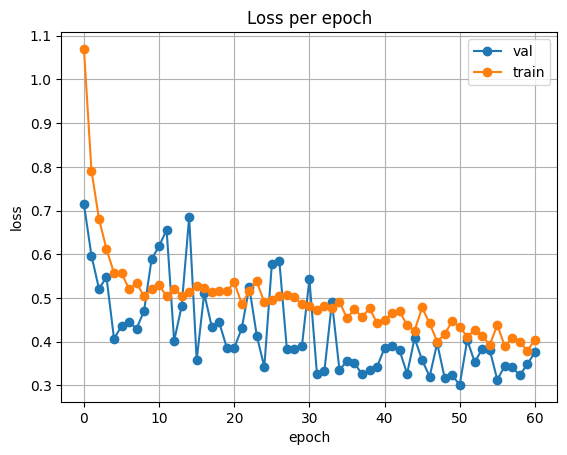

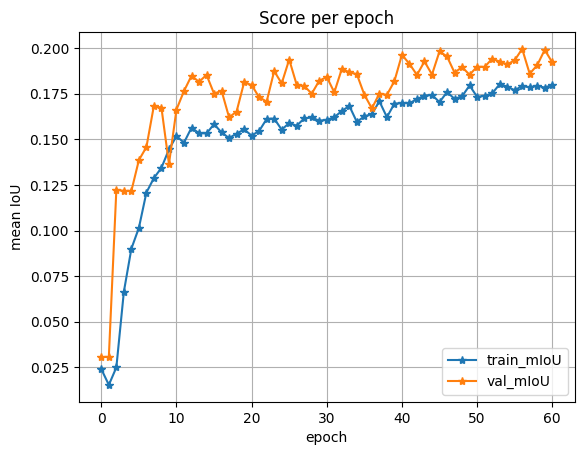

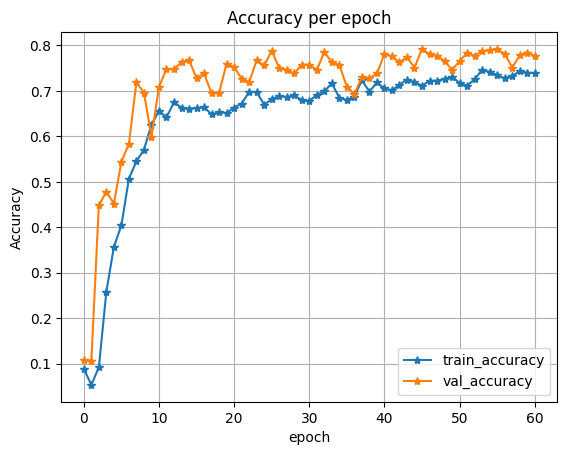

In [55]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(history)
plot_score(history)
plot_acc(history)

In [56]:
CLASS_COLORS = [
    [0, 0, 0],         # Class 0: Background
    [255, 0, 0],       # Class 1
    [0, 255, 0],       # Class 2
    [0, 0, 0],         # Class 3 (part of background)
    [255, 255, 0],     # Class 4
    [0, 255, 255],     # Class 5
]

In [57]:
def evaluate_model(model, loader, device, num_classes):
    """
    Calculates the test mIOU, pixel accuracy, and loss.
    """
    print("Evaluating model...")
    model.eval()
    
    total_iou = 0.0
    total_accuracy = 0.0
    total_loss = 0.0
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluation"):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate pixel accuracy
            correct = (preds == masks).sum().item()
            total = masks.nelement()
            total_accuracy += correct / total
            
            # Calculate IoU for each class and then the mean
            iou_per_batch = 0.0
            for cls in range(num_classes):
                pred_inds = preds == cls
                target_inds = masks == cls
                intersection = (pred_inds[target_inds]).long().sum().item()
                union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
                if union == 0:
                    iou_per_batch += 1.0 # If there is no ground truth or prediction for this class, score is 1
                else:
                    iou_per_batch += intersection / union
            total_iou += iou_per_batch / num_classes
            
    avg_loss = total_loss / len(loader)
    avg_accuracy = total_accuracy / len(loader)
    avg_iou = total_iou / len(loader)
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    print(f"Test mIOU: {avg_iou:.4f}")

In [58]:
def masks_to_color_img(mask, class_colors):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in enumerate(class_colors):
        color_mask[mask == class_id] = color
    return color_mask

def save_and_display_predictions(model, loader, device, output_dir="test_predictions"):
    print(f"Saving prediction images to '{output_dir}/'...")
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    file_counter = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Generating Predictions"):
            images = images.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            images_cpu = images.cpu()
            masks_cpu = masks.cpu().numpy()
            preds_cpu = preds.cpu().numpy()

            for i in range(images_cpu.size(0)):
                img_np = images_cpu[i].numpy().transpose(1, 2, 0)
                img_np = (img_np * std + mean)
                img_np = np.clip(img_np, 0, 1)

                true_mask_np = masks_cpu[i]
                pred_mask_np = preds_cpu[i]

                true_mask_color = masks_to_color_img(true_mask_np, CLASS_COLORS)
                pred_mask_color = masks_to_color_img(pred_mask_np, CLASS_COLORS)

                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
                
                ax1.imshow(img_np)
                ax1.set_title("Original Image")
                ax1.axis('off')
                
                ax2.imshow(true_mask_color)
                ax2.set_title("Ground Truth Mask")
                ax2.axis('off')

                ax3.imshow(pred_mask_color)
                ax3.set_title("Predicted Mask")
                ax3.axis('off')
                
                plt.tight_layout()
                
                save_path = os.path.join(output_dir, f"prediction_{file_counter}.png")
                plt.savefig(save_path)
                plt.close(fig)
                
                file_counter += 1

    print(f"Finished. All {file_counter} prediction images have been saved.")

In [59]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,
)
model.load_state_dict(torch.load('model_transfer_learning.pt', map_location=device))
model.to(device)
save_and_display_predictions(model, test_loader, device=device)
evaluate_model(model, test_loader, device=device, num_classes=6)


Saving prediction images to 'test_predictions/'...


Generating Predictions: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 22/22 [01:59<00:00,  5.44s/it]


Finished. All 339 prediction images have been saved.
Evaluating model...


Evaluation: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 22/22 [01:48<00:00,  4.92s/it]

Test Loss: 0.4640
Test Accuracy: 0.7760
Test mIOU: 0.3131


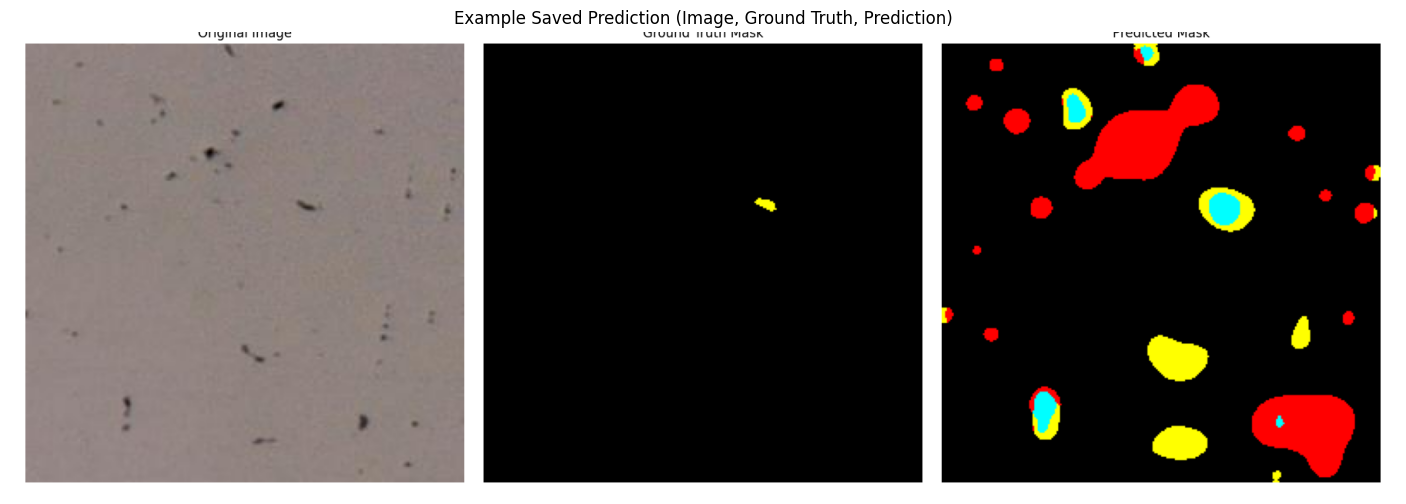

In [60]:
try:
    first_prediction = cv2.imread('./test_predictions/prediction_0.png')
    first_prediction = cv2.cvtColor(first_prediction, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18,6))
    plt.imshow(first_prediction)
    plt.axis('off')
    plt.title("Example Saved Prediction (Image, Ground Truth, Prediction)")
    plt.show()
except Exception as e:
    print(f"Could not display example image. Error: {e}")